In [1]:
import seaborn as sns
from PIL import Image
from traffic_sim.matrix import TrafficMatrix
from traffic_sim.matrix import WeightedMatrix
from traffic_sim.sim import TrafficSim

In [2]:
tm = WeightedMatrix(10, 10, density=0.02)
# set traffic capacities (hardcoded)
tm.cmatrix[:, 2] = 2
tm.cmatrix[:, 8] = 2
tm.cmatrix[3, :] = 3
tm.cmatrix[:, 5] = 4
tm.set_weights()

<AxesSubplot:>

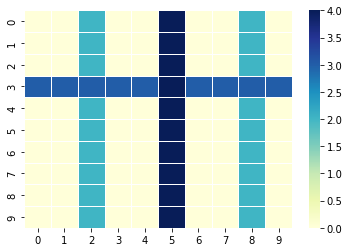

In [3]:
sns.heatmap(tm.cmatrix, cmap="YlGnBu", linewidth=0.5)

<AxesSubplot:>

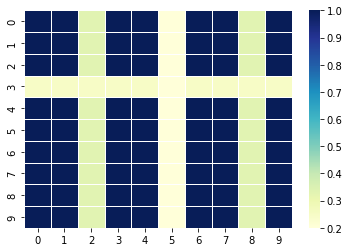

In [4]:
sns.heatmap(tm.wmatrix, cmap="YlGnBu", linewidth=0.5)

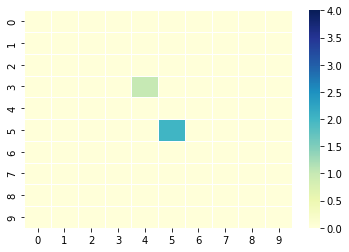

In [5]:
# simulate traffic
sim = TrafficSim(tm)
sim.run(10)
sim.savefig('traffic_sim')

In [6]:
for idx, history in enumerate(sim.history):
    flows = history["flows"]
    print("Step {0}".format(idx))
    for flow in flows:
        print("{0} -> {1} | Goal: {2} | Possible Moves: {3}".format(
            flow.prev,
            flow.location,
            flow.dest,
            flow.possible_moves
        ))

Step 0
(3, 3) -> (3, 4) | Goal: (3, 4) | Possible Moves: {(3, 3): 0.25, (3, 2): 0.5, (3, 4): 0.0}
(9, 8) -> (9, 8) | Goal: (9, 8) | Possible Moves: {(8, 8): 0.3333333333333333, (9, 8): 0.0}
Step 1
(3, 3) -> (3, 4) | Goal: (3, 4) | Possible Moves: {(3, 3): 0.25, (3, 2): 0.5, (3, 4): 0.0}
(5, 5) -> (5, 5) | Goal: (5, 8) | Possible Moves: {(4, 5): 0.632455532033676, (5, 5): 0.6000000000000001, (6, 5): 0.632455532033676}
Step 2
(3, 3) -> (3, 4) | Goal: (3, 4) | Possible Moves: {(3, 3): 0.25, (3, 2): 0.5, (3, 4): 0.0}
(5, 5) -> (5, 5) | Goal: (5, 8) | Possible Moves: {(4, 5): 0.632455532033676, (5, 5): 0.6000000000000001, (6, 5): 0.632455532033676}
Step 3
(3, 3) -> (3, 4) | Goal: (3, 4) | Possible Moves: {(3, 3): 0.25, (3, 2): 0.5, (3, 4): 0.0}
(5, 5) -> (5, 5) | Goal: (5, 8) | Possible Moves: {(4, 5): 0.632455532033676, (5, 5): 0.6000000000000001, (6, 5): 0.632455532033676}
Step 4
(5, 5) -> (5, 5) | Goal: (5, 8) | Possible Moves: {(4, 5): 0.632455532033676, (5, 5): 0.6000000000000001, (6, 